In [ ]:
#default_exp synchro.processing
%load_ext autoreload
%autoreload 2

# synchro.processing
> Processing functions to align stimuli, detect frame timings and correct errors of the display.

In [ ]:
#export
import numpy as np
import datetime
import glob
import os
from scipy import signal

In [ ]:
#export
def get_thresholds(data):
    """Function that attempts to get the high and low thresholds. Not working very well"""
    max_val = max(data[len(data)//2:len(data)//2 + 10000000]) #Looking for a max in a portion of the data, from the middle
    high_thresh = max_val*3/4 # High threshold set at 3/4th of the max
    low_thresh  = max_val*1/4
    return low_thresh, high_thresh

In [ ]:
from theonerig.synchro.io import *
from theonerig.core import *
from theonerig.utils import *
import matplotlib.pyplot as plt
photodiode_data = load_adc_raw("./files/basic_synchro/photodiode_data", sampling_rate=30000)

Loading the data... 100%      


Supposidly, get_thresholds should provide low and high threshold for the data, but the low_treshold is a sensitive value that should be checked manually in a record

In [ ]:
#export
def get_first_high(data, threshold):
    if np.any(data>threshold):
        return np.argmax(data>threshold)
    else:
        return -1

`get_first_high` finds the idx of the first frame higher than the threshold

In [ ]:
#export
def detect_frames(data, low_threshold, high_threshold, increment, do_reverse=True):
    """Frame detection (or ON signal detection). Capable of finding frame times produced in a regular
    fashion:
        - data: raw data
        - low_threshold: threshold used to detect begginning of each frame.
        - high_threshold: threshold used to assign label to the frames, and used to detect the beggining of the reading frame.
        - do_reverse: boolean to indicate if the reverse detection should be done after detecting the first frame."""
    frame_timepoints, frame_signals = [], []
    safe_increment = int(increment*95/100)

    first_high = get_first_high(data, high_threshold)
    if first_high == -1:
        print("No high frame detected. Detection can't work.")
        return

    frame_timepoints.append(first_high)
    frame_signals.append(1)
    
    if do_reverse:
        new_timepoints   = reverse_detection(data, frame_timepoints, low_threshold, increment)
        if len(new_timepoints)>1:
            new_extrapolated = extend_timepoints(new_timepoints)
        else:
            new_extrapolated = []
        frame_timepoints = new_extrapolated + new_timepoints + frame_timepoints
        frame_signals    = [0]*(len(new_timepoints)+len(new_extrapolated)) + frame_signals

    i = first_high + safe_increment
    while i < len(data):
        data_slice = data[i:i+increment//2]
        if np.any(data_slice>low_threshold):
            i = i+np.argmax(data_slice>low_threshold)
        else:
            break #This frame sequence is over. Pass the next sequence through this function if there are frames left
        frame_timepoints.append(i)
        frame_signals.append(int(np.any(data_slice > high_threshold)))
        i += safe_increment

    frame_timepoints = np.array(frame_timepoints)
    frame_signals    = np.array(frame_signals)
    frame_timepoints = frame_timepoints - 3 # A slight shift of the timepoints 
                                            # to include the begginning of the peaks.
        
    error_check(frame_timepoints)

    return frame_timepoints, frame_signals

def reverse_detection(data, frame_timepoints, low_threshold, increment):
    """Detect frames in the left direction."""
    new_timepoints = []
    new_signals = []

    safe_increment = int(increment * 105/100)

    i = frame_timepoints[0]-safe_increment
    while i>0:
        data_slice = data[i:i+increment//2]
        if np.any(data_slice > low_threshold):
            i = i+np.argmax(data_slice > low_threshold)
        else:
            break #No low threshold crossing found -> no more frames to detect
        new_timepoints.append(i)
        i-= safe_increment #We move backward of almost a frame

    return new_timepoints[::-1]

def extend_timepoints(frame_timepoints, n=10):
    """Extrapolates points to the left. Not really needed now except for the signals idx that would change
    otherwise (and some starting index were set manually)"""
    frame_timepoints = np.array(frame_timepoints)
    typical_distance = int(np.mean(np.diff(frame_timepoints)))
    extended_tp = [frame_timepoints[0]-(i+1)*typical_distance for i in range(n) if (frame_timepoints[0]-(i+1)*typical_distance)>0]
    return extended_tp[::-1]

def error_check(frame_tp):
    """Search error by looking at the time between each frame. 
    DLP is regular and odd time reveal misdetections."""
    deriv_frame_tp = np.diff(frame_tp)
    error_len_th = np.mean(deriv_frame_tp)+np.std(deriv_frame_tp)*6

    error_frames = np.abs(deriv_frame_tp)>error_len_th
    if np.any(error_frames):
        print("Error in timepoints detected in frames", np.where(error_frames)[0], 
              "at timepoint", frame_tp[np.where(error_frames)[0]])

detect_frames do frame detection. Works for camera pulses and photodiode data emitted by a DLP. It does it by:
* Finding the first frame higher than a threshold
* Detecting the frames before if flag do_reverse is set to True
* Detect frames
* Assign a binary value of if it's higher than the high threshold
* Do a quick check on the frames to spot weird results

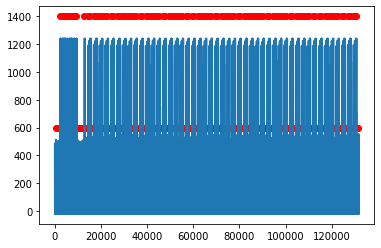

In [ ]:
frame_timepoints, frame_signals = detect_frames(photodiode_data, 200, 1000, increment=500)
plt.figure()
plt.plot(photodiode_data)
plt.scatter(frame_timepoints, frame_signals*800+600, c="r")

In [ ]:
#export
def cluster_frame_signals(data, frame_timepoints, n_cluster=5):
    """Cluster the `frame_timepoints` in `n_cluster` categories depending on the area under the curve.
        - data: raw data used to compute the AUC
        - frame_timepoints: timepoints delimitating each frame
        - n_cluster: Number of cluster for the frame signals"""
    frame_aucs = np.fromiter(map(np.trapz, np.split(data, frame_timepoints)), float)
    if frame_timepoints[0] != 0: #We need to remove the first part if it wasn't a full frame
        frame_aucs = frame_aucs[1:]
    frame_auc_sorted = np.sort(frame_aucs)
    deriv = np.array(frame_auc_sorted[1:]-frame_auc_sorted[:-1])
    deriv[:5]  = 0 #removing tails values that can show weird stuff
    deriv[-5:] = 0
    threshold_peak = np.std(deriv)*3
    n          = n_cluster - 1
    idx_gaps = np.zeros(n+3, dtype="int")
    tmp_deriv = deriv.copy()
    zero_set_range = 10#int(len(deriv)*0.05) #Around the peaks, we set the values to 0 around
    for i in range(n+3): #Detecting more peaks than needed and then taking them starting on the right
        if tmp_deriv[np.argmax(tmp_deriv)] < threshold_peak:
            if i<n_cluster-1:
                print("Less transition in AUC detected than needed, results will be weird")
            break
        idx_gaps[i] = np.argmax(tmp_deriv)
        tmp_deriv[idx_gaps[i]-zero_set_range:idx_gaps[i]+zero_set_range] = 0
    idx_gaps = np.sort(idx_gaps)
    idx_gaps = idx_gaps[-(n_cluster-1):]
    thresholds = np.zeros(n, dtype="float")
    for i, idx in enumerate(idx_gaps):
        thresholds[i] = (frame_auc_sorted[idx+1] + frame_auc_sorted[idx])/2

    return np.array([np.sum(auc>thresholds) for auc in frame_aucs], dtype=int)

def cluster_by_epochs(data, frame_timepoints, frame_signals, epochs):
    """Does the same thing as `cluster_frame_signals`, but working on epochs around which the
    number of cluster can differ. Useful when a record contains stimuli with different signals sizes."""

    frame_aucs = np.fromiter(map(np.trapz, np.split(data, frame_timepoints)), float)
    if frame_timepoints[0] != 0: #We need to remove the first part if it wasn't a full frame
        frame_aucs = frame_aucs[1:]

    max_cluster = max([nclust-1 for (_,_,nclust) in epochs])
    
    for start,stop,n_cluster in epochs:
        n          = n_cluster - 1
        norm_clust = max_cluster/n
        frame_auc_sorted = np.sort(frame_aucs[start:stop])
        deriv = np.array(frame_auc_sorted[1:]-frame_auc_sorted[:-1])
        deriv[:5]  = 0 #removing tails values that can show weird stuff
        deriv[-5:] = 0
        idx_gaps   = np.zeros(n, dtype="int")
        tmp_deriv = deriv.copy()
        zero_set_range = 10
        for i in range(n):
            idx_gaps[i] = np.argmax(tmp_deriv)
            tmp_deriv[idx_gaps[i]-zero_set_range:idx_gaps[i]+zero_set_range] = 0
        idx_gaps = np.sort(idx_gaps)
        thresholds = np.zeros(n, dtype="float")
        for i, idx in enumerate(idx_gaps):
            thresholds[i] = (frame_auc_sorted[idx+1] + frame_auc_sorted[idx])/2

        frame_signals[start:stop] = np.array([np.sum(auc>thresholds)*norm_clust for auc in frame_aucs[start:stop]], dtype=int)
    return frame_signals

In [ ]:
#export
def cluster_by_list(data, frame_timepoints, frame_signals, stim_list):
    """Assign the stimulus identity values from stim_list to the frames in data. stim_list contains only the 
        sequence of stimuli. Those need to be expanded. Opposed to cluster_frame_signals and cluster_by_epochs no 
        AUC operation is performed. 
        Input:
            - data: raw data used to compute the AUC
            - frame_timepoints: timepoints delimiting each frame
            - frame_signals: binary 1-D numpy array indicating if high_threshold was passed in 'detect_frames'
            - stim_list: 1-D numpy array containing the sequence of the stimuli presented
        Output:
            - frame_signals: [same size as frame_timepoints] stim_signals list containing the correct value from 
                stim_list at every entry"""
    # Determine the stimulus on- and offsets and their location relative to data
    stim_change = np.where(frame_signals[:-1] != frame_signals[1:])[0] 
    stim_change = stim_change + 1 # since I need to compare to [1:] all values are shifted by 1
    #stim_idx = frame_timepoints[stim_change]
    
    # QDSpy currently is set to emit a short peak at the end to indicate the end of the stimulus presentation
    # This peak needs to be ignored
    epoch_end = stim_change[-2:-1] # return it for future analysis
    stim_change[-2:-1] = 0 #add it to the no stimulus category

    # Split into on times & values vs off times & values
    stim_ons = stim_change[0::2]
    #stim_ons_idx = stim_idx[0::2]
    stim_offs = stim_change[1::2]
    #stim_offs_idx = stim_idx[1::2]
    
    # Replace the frame_signal entries with the stimulus codes
    frame_signals[frame_signals == 0] = -1 # To avoid confusion with the '0' stimulus code
    for i,stim_type in enumerate(stim_list):
        frame_signals[stim_ons[i]:stim_offs[i]] = stim_type
   
    return frame_signals, stim_ons, stim_offs, epoch_end

Frame signals are then refined using cluster_frame_signals of the signals to attribute them a value in a defined range

In [ ]:
frame_signals = cluster_frame_signals(photodiode_data, frame_timepoints, n_cluster=5)

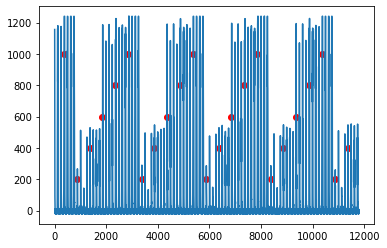

In [ ]:
plt.figure()
plt.plot(photodiode_data[120000:131800])
plt.scatter(frame_timepoints[frame_timepoints>120000]-120000, frame_signals[frame_timepoints>120000]*200+200, c='r')

With the frame detected, we can create our record master, often named reM

In [ ]:
ref_timepoints, ref_signals = extend_sync_timepoints(frame_timepoints, frame_signals, up_bound=len(photodiode_data))
reM = RecordMaster([(ref_timepoints, ref_signals)])
print(len(reM[0]))

265


Though the reM we just created is from a tiny portion of real data. From now one we will use a premade reM generated from the same dataset, in full.

In [ ]:
reM = import_record("./files/basic_synchro/reM_basic_synchro.h5")

Importing the record master



In [ ]:
#export
def parse_time(time_str, pattern="%y%m%d_%H%M%S"):
    """Default parser of rhd timestamps. (serve as a template too)"""
    return datetime.datetime.strptime(time_str, pattern)

def get_position_estimate(stim_time, record_time, sampling_rate):
    """Estimate where in the record should a stimulus start, in sample points"""
    if stim_time < record_time:
        return -1
    else:
        return (stim_time - record_time).seconds * sampling_rate

In [ ]:
record_time = parse_time("200331_170849") #Starting time of that example record found on the filename of the record
print(record_time)

2020-03-31 17:08:49


In [ ]:
#export
def match_starting_position(frame_timepoints, frame_signals, stim_signals, estimate_start):
    stim_matching_len = min(600, np.where(np.diff(stim_signals)!=0)[0][50]) #Way of getting the 50th change in the signals
    #But not higher than 600 (correspond to 10s, and is necessary for moving gratings)
#     stim_matching_len = 50
    idx_estimate = np.argmax(frame_timepoints>estimate_start)
    search_slice = slice(max(0, idx_estimate-1000), min(idx_estimate+1000, len(frame_signals)))
#     diff_signals = np.diff(frame_signals[search_slice])
#     diff_stim    = np.diff(stim_signals[:stim_matching_len])
#     return search_slice.start + np.argmax(np.correlate(diff_signals, diff_stim))
    return search_slice.start + np.argmax(np.correlate(frame_signals[search_slice], 
                                                       stim_signals[:stim_matching_len]))


match_starting_position seaks in the record the first frame of a stimulus. We can use functions from theonerig.synchro.extracting to find out the stimuli used in that record, and get their values

In [ ]:
from theonerig.synchro.extracting import get_QDSpy_logs, unpack_stim_npy
log = get_QDSpy_logs("./files/basic_synchro")[0]

IndexError: list index out of range

In [ ]:
print(log.stimuli[2])

In [ ]:
#Unpacking the stimulus printed above
unpacked_checkerboard = unpack_stim_npy("./files/basic_synchro/stimulus_data", "eed21bda540934a428e93897908d049e")
print(unpacked_checkerboard[0].shape, unpacked_checkerboard[1].shape, unpacked_checkerboard[2])

get_position_estimate can approximately tell us where the stimulus should be to reduce the search time

In [ ]:
estimate_start = get_position_estimate(log.stimuli[2].start_time, record_time, sampling_rate=30000)
print("Estimate position in sample points", estimate_start)

In [ ]:
stim_start_frame = match_starting_position(reM["main_tp"][0], reM["signals"][0], stim_signals=unpacked_checkerboard[1], estimate_start=estimate_start)
print(stim_start_frame)

In [ ]:
#export
def display_match(match_position, reference=None, recorded=None, corrected=None, len_line=50):
    start, mid, end = 0, len(reference)//2, len(reference)-len_line
    for line in [start, mid, end]:
        if reference is not None:
            print("REF ["+str(line)+"] "," ".join(map(str,map(int, reference[line:line+len_line]))))
        if recorded is not None:
            print("REC ["+str(line)+"] "," ".join(map(str,map(int, recorded[line+match_position:line+len_line+match_position]))))
        if corrected is not None:
            print("COR ["+str(line)+"] "," ".join(map(str,map(int, corrected[line:line+len_line]))))
        print()

Let's see the match we obtain

In [ ]:
display_match(stim_start_frame, reference=unpacked_checkerboard[1], recorded=reM["signals"][0])

We have a match!! But be sure to check it everytime, as mismatches occurs. Set then stim_start_frame manually

In [ ]:
#export
def frame_error_correction(signals, unpacked, algo="nw", **kwargs):
    """Correcting the display stimulus frame values. Shifts are first detected with one of
    `shift_detection_conv` or `shift_detection_NW` and applied to the stimulus template. Then single frame
    mismatch are detected and corrected.
        - signals: true signal values recorded
        - unpacked: stimulus tuple (inten,marker,shader)
        - algo: algorithm for shift detection among [nw, conv]
        - **kwargs: extra parameter for shift detection functions
        
        returns: stim_tuple_corrected, shift_log, (error_frames_idx, replacement_idx)"""
    
    if algo=="no_shift":
        intensity, marker, shader  = unpacked[0].copy(), unpacked[1].copy(), unpacked[2]
        if shader is not None:
            shader = shader.copy()
        error_frames, replacements = error_frame_matches(signals, marker, range_=5)
        shift_log = []
    else:
        if algo=="nw":
            shift_log = shift_detection_NW(signals.astype(int), unpacked[1].astype(int), **kwargs)
        elif algo=="conv":
            shift_log = shift_detection_conv(signals.astype(int), unpacked[1].astype(int), range_=5, **kwargs)
        intensity, marker, shader = apply_shifts(unpacked, shift_log)
        error_frames, replacements = error_frame_matches(signals, marker, range_=5)
    if len(error_frames)>0:
        intensity[error_frames]    = intensity[replacements]
        marker[error_frames]       = marker[replacements]
        if shader is not None:
            shader[error_frames] = shader[replacements]
    return (intensity, marker, shader), shift_log, list(zip(map(int,error_frames), map(int,replacements)))

def error_frame_matches(signals, marker, range_):
    """Find the frames mismatching and finds in the record the closest frame with an identical signal value"""
    error_frames = np.nonzero(signals!=marker)[0]
    if len(error_frames)>0:
        where_equal = [((np.where(marker[err_id-range_:err_id+(range_+1)] == signals[err_id])[0]) - range_) for err_id in error_frames]
    #filtering out the frames where no match was found
        tmp    = np.array([[wheq,err] for (wheq, err) in zip(where_equal, error_frames) if len(wheq)>0])
        if len(tmp)==0:
            replacements = np.empty(shape=(0,), dtype=int)
            error_frames = np.empty(shape=(0,), dtype=int)
        else:
            where_equal  = tmp[:,0]
            error_frames = tmp[:,1]

        #Choosing among the equal frame signals the one that is the closest
            closest_equal = [wheq[(np.abs(wheq)).argmin()] for wheq in where_equal]
            error_frames  = np.array(error_frames, dtype=int)
            replacements  = error_frames + np.array(closest_equal, dtype=int)
    else:
        replacements = np.empty(shape=(0,), dtype=int)
        error_frames = np.empty(shape=(0,), dtype=int)
    
    return error_frames, replacements

def apply_shifts(unpacked, op_log):
    """Applies the shifts found by either shift_detection functions"""
    inten, marker, shader = unpacked[0].copy(), unpacked[1].copy(), unpacked[2]
    if shader is not None:
        shader = shader.copy()
    orig_len = len(marker)
    for idx, op in op_log:
        if op=="ins": #We insert a frame
            marker = np.insert(marker, idx, marker[idx], axis=0)
            inten  = np.insert(inten , idx, inten[idx], axis=0)
            if shader is not None:
                shader = np.insert(shader, idx, shader[idx], axis=0)
        elif op=="del": #We concatenate without the deleted frame
            marker = np.concatenate((marker[:idx],marker[idx+1:]))
            inten  = np.concatenate((inten[:idx],inten[idx+1:]))
            if shader is not None:
                shader = np.concatenate((shader[:idx],shader[idx+1:]))
    marker = marker[:orig_len]
    inten  = inten[:orig_len]
    if shader is not None:
        shader = shader[:orig_len]
    return (inten, marker, shader)

def shift_detection_conv(signals, marker, range_):
    """Detect shifts with a convolution method. First look at how far the next closest frame are, and average
    it over the record. When the average cross the -1 or 1 threshold, shift the reference accordingly."""
    marker = marker.copy()
    shift_detected = True
    shift_log = []
    while shift_detected:
        error_frames, replacements = error_frame_matches(signals, marker, range_)

        all_shifts = np.zeros(len(marker))
        all_shifts[error_frames] = replacements-error_frames
        all_shifts_conv = np.convolve(all_shifts, [1/20]*20, mode="same") #Averaging the shifts to find consistant shifts

        shift_detected = np.any(np.abs(all_shifts_conv)>.5)
        if shift_detected: #iF the -.5 threshold is crossed, we insert a "fake" frame in the reference and we repeat the operation
            change_idx = np.argmax(np.abs(all_shifts_conv)>.5)
            if all_shifts_conv[change_idx]>.5:#Need to delete frame in reference
                #Need to refine index to make sure we delete a useless frame
                start,stop = max(0,change_idx-2), min(len(marker),change_idx+2)
                for i in range(start,stop):
                    if marker[i] not in signals[start:stop]:
                        change_idx = i
                        break
                shift_log.append([int(change_idx), "del"])
                marker = np.concatenate((marker[:change_idx], marker[change_idx+1:], [0]))
            else:#Need to insert frame in reference
                shift_log.append([int(change_idx), "ins"])
                #inserting a frame and excluding the last frame to keep the references the same length
                marker     = np.insert(marker, change_idx, marker[change_idx], axis=0)[:-1] 
    return shift_log

def shift_detection_NW(signals, marker, simmat_basis=[1,-1,-3,-3,-1], insdel=-10, rowside=20):
    """Memory optimized Needleman-Wunsch algorithm.
    Instead of an N*N matrix, it uses a N*(side*2+1) matrix. Indexing goes slightly differently but
    result is the same, with far less memory consumption and exection speed scaling better with
    size of the sequences to align."""
    #Setting the similarity matrix
    side = rowside
    sim_mat = np.empty((len(marker), side*2+1), dtype="int32")
    #Setting the errors
    insertion_v = insdel #insertions are commons not so high penalty
    deletion_v  = insdel #deletions detection happens during periods of confusion but are temporary. High value
    error_match = np.array(simmat_basis) #The value for a 0 matching with [0,1,2,3,4]
    error_mat = np.empty((len(simmat_basis),len(simmat_basis)))
    for i in range(len(simmat_basis)):
        error_mat[i] = np.roll(error_match,i)
                
    #Filling the similarity matrix
    sim_mat[0, side] = error_mat[marker[0], signals[0]]
    #Initialization: Setting the score of the first few row and first few column cells
    for j in range(side+1, side*2+1):
        sim_mat[0,j] = sim_mat[0,side] + insertion_v*j
    for i in range(1, side+1):
        sim_mat[i,side-i] = sim_mat[0,side] + deletion_v*i
          
    #Corpus: if j is the first cell of the row, the insert score is set super low
    #        if j is the last  cell of the row, the delete score is set super low
    for i in range(1, sim_mat.shape[0]):
        start = max(side-i+1, 0)
        stop  = min(side*2+1, side+sim_mat.shape[0]-i)
        for j in range(start, stop):
            if j==0:#j==start and i>side:
                insert = -99999
                delete = sim_mat[i-1, j+1] + deletion_v
            elif j==side*2:
                delete = -99999
                insert = sim_mat[i, j-1] + insertion_v
            else:
                insert = sim_mat[i, j-1] + insertion_v
                delete = sim_mat[i-1, j+1] + deletion_v
            match  = sim_mat[i-1, j] + error_mat[marker[i], signals[j+i-side]]
            sim_mat[i,j] = max(insert,delete,match)
            
    #Reading the similarity matrix
    #In general, it's the same, at the difference that when i decrement, must add 1 to j compared to usual.
    i = len(marker)-1
    j = side
    shift_log = []
    while (i > 0 or j>side-i):
        if (i > 0 and j>side-i and sim_mat[i,j]==(sim_mat[i-1,j]+error_mat[marker[i], signals[j+i-side]])):
            i -= 1
        elif(i > 0 and sim_mat[i,j] == sim_mat[i-1,j+1] + deletion_v):
            shift_log.insert(0,(j+i-side+1, "del")) #Insert the j value for deletion too because all shifts
            i-=1                                        #are relative to the signals recorded, unlike normal NW
            j+=1
        else:
            shift_log.insert(0,(j+i-side, "ins"))
            j-=1
                
    return shift_log

We correct the stimulus values with frame_error_correction and it gives us back the changes it made to keep track of the errors made.

In [ ]:
signals = reM["signals"][0][stim_start_frame:stim_start_frame+len(unpacked_checkerboard[0])]
corrected_checkerboard, shift_log, error_frames = frame_error_correction(signals, unpacked_checkerboard, algo="nw")
print(shift_log, len(error_frames))

In [ ]:
#export
def chop_stim_edges(first_frame, last_frame, stim_tuple, shift_log, frame_replacement):
    """Cut out the stimulus parts not containing actual stimulus, and change the idx values of `shift_log`
    and `frame_replacement` to match the new indexing."""
    inten, marker, shader = stim_tuple
    if last_frame<0: #Using negative indexing
        last_frame = len(marker)+last_frame
    inten = inten[first_frame:last_frame]
    marker = marker[first_frame:last_frame]
    if shader is not None:
        shader = shader[first_frame:last_frame]
    
    shift_log = [(shift[0]-first_frame, shift[1]) for shift in shift_log if shift[0]<last_frame]
    frame_replacement = [(fr[0]-first_frame, fr[1]-first_frame) for fr in frame_replacement if fr[0]<last_frame]
    
    return (inten, marker, shader), shift_log, frame_replacement

In [ ]:
#export
def detect_calcium_frames(scanning_data, epoch_threshold=-8):
    """Detect the timing of the 2P frames, epoch by epoch over a record."""
    
    #Finds the start of a stack recording
    start_set = np.where((scanning_data[1:] > epoch_threshold) & (scanning_data[:-1] < epoch_threshold))[0]
    #Finds the end of a stack recording
    end_set   = np.where((scanning_data[1:] < epoch_threshold) & (scanning_data[:-1] > epoch_threshold))[0]
    #Splits the records into the epochs
    list_epoch = np.array_split(scanning_data, np.ravel(list(zip(start_set, end_set))))[1::2]

    def detect_peak_sync(epoch):
        #Finds the peaks in an epoch. Peaks have strong SNR so this works fine
        return signal.find_peaks(epoch, prominence=2)[0]

    return [arr + start_set[i] for i, arr in enumerate(list(map(detect_peak_sync, list_epoch)))]

In [ ]:
#hide
from nbdev.export import *
notebook2script()